In [1]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler
import hdbscan

from tqdm import trange
from scipy.spatial.distance import cdist
from scipy.stats import randint
import clustering

In [14]:
from IPython.core.interactiveshell import InteractiveShell
from importlib import reload
reload(clustering)
from clustering import *

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
InteractiveShell.ast_node_interactivity = 'all'
sns.set()
sns.set(rc={'figure.figsize':(12,8)})

<module 'clustering' from 'C:\\Users\\LCI_user\\Documents\\GitHub\\LCI-Clustering\\clustering.py'>

## Loading Data

In [3]:
df = pd.read_csv('Diskovery_Cell1_ThunderSTORM.csv')
df.head()
df = df.sort_values(by=['intensity [photon]'])

,id,frame,x [nm],y [nm],sigma [nm],intensity [photon],offset [photon],bkgstd [photon],uncertainty [nm]
0,1.0,1.0,2474.998618,6736.088180,195.815722,1841.965445,80.087915,10.501425,9.781846
1,2.0,1.0,4356.136836,14133.322371,145.009192,5599.702004,82.962749,24.851702,4.184589
2,3.0,1.0,4542.775300,9091.265025,121.313419,221.442108,39.507939,4.162599,15.045367
3,4.0,1.0,5977.444344,7594.973438,137.276419,155.518749,39.499220,4.681645,24.730111
4,5.0,1.0,6079.459555,11231.168432,137.261612,2693.631410,59.415820,11.278048,4.647010


## Displaying Raw Data

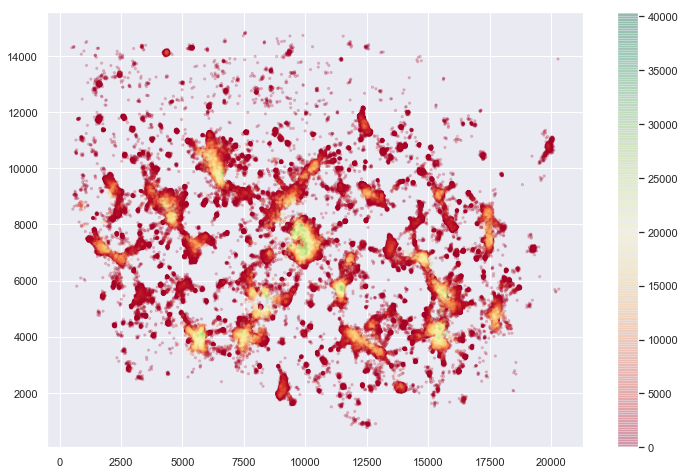

In [5]:
img = plt.scatter(df['x [nm]'],
                  df['y [nm]'],
                  c=df['intensity [photon]'],
                  s=5, cmap='RdYlGn',alpha=0.2)
_ = plt.colorbar(img)

## Applying DBSCAN

In [5]:
%matplotlib widget
sns.set(rc={'figure.figsize':(6,6)})

(0.6951561008242889, 0.002424250715831411)

Estimated number of clusters: 96
Estimated number of noise points: 3722
Total number of points: 89939


FigureCanvasNbAgg()

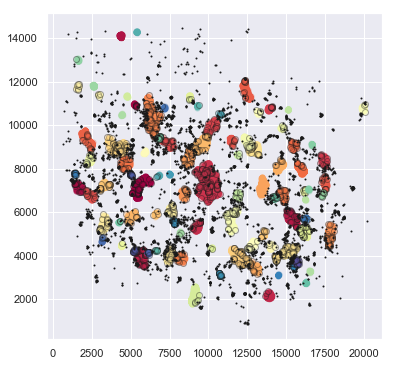

In [8]:
XY = np.column_stack((df['x [nm]'],df['y [nm]']))[::10]

db = DBSCAN(eps=147, min_samples=73, n_jobs=6)
custom_silhouette(db,XY,cv=2)
dbscan_verbose(db, XY, plot=True)

## RipleyK test

In [ ]:
from astropy.stats import RipleysKEstimator
labels = db.labels_
z = XY[labels==0] / 1000

Kest = RipleysKEstimator(area=4, x_max=6.4, y_max=7.7, x_min=5, y_min=6.6)

r = np.linspace(0, 2, 100)
plt.plot(r, Kest.poisson(r), color='green', ls=':', label=r'$K_{pois}$')
plt.plot(r, Kest(data=z, radii=r, mode='none'), color='red', ls='--',
         label=r'$K_{un}$')
plt.plot(r, Kest(data=z, radii=r, mode='translation'), color='black',
         label=r'$K_{trans}$')
# plt.plot(r, Kest(data=z, radii=r, mode='ohser'), color='blue', ls='-.',
#          label=r'$K_{ohser}$')
# plt.plot(r, Kest(data=z, radii=r, mode='var-width'), color='green',
#          label=r'$K_{var-width}$')
# plt.plot(r, Kest(data=z, radii=r, mode='ripley'), color='yellow',
#          label=r'$K_{ripley}$')

plt.legend()

In [ ]:
dbscan_verbose(db, XY, plot=True,n=[0])

## Sparse neighbor distance matrix

Try this again next time and throw into DBSCAN to see if performance improves

In [39]:
from sklearn.neighbors import radius_neighbors_graph

coords = np.column_stack((df['x [nm]'],df['y [nm]']))[::50]

test = radius_neighbors_graph(X=coords, radius=200, mode='distance')
test.todense()

384208785.9220097

In [40]:
dbscan = DBSCAN(n_jobs=6,metric='precomputed',eps=1000,min_samples=5)

param_dist = {"eps": randint(120, 200),
              "min_samples": randint(30, 300)}

def custom_silhouette2(dbscan,X):
    db = dbscan.fit(X)
    labels = db.labels_
    score = silhouette_score(X.todense().T, labels, metric="precomputed")
    
    return score

custom_silhouette2(dbscan,test)

-0.9919946631087392

Estimated number of clusters: 97
Estimated number of noise points: 436
Total number of points: 17988


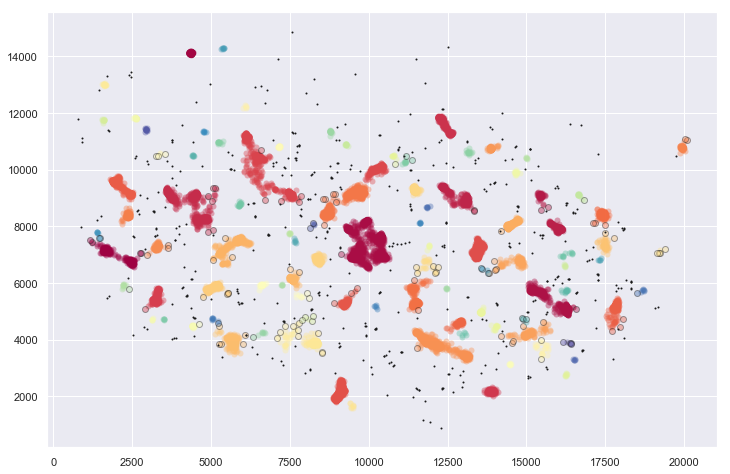

In [36]:
dbscan_verbose(dbscan, coords, plot=True)

## Hyper Parameter Search

In [ ]:
dbscan = DBSCAN(n_jobs=6)

param_dist = {"eps": randint(120, 200),
              "min_samples": randint(30, 300)}
    
results = random_search_custom(dbscan,param_dist,XY,n=200,cv=3)
results

## HDBSCAN Test

In [24]:
# XY = np.column_stack((df['x [nm]'],df['y [nm]']))[::5]
XY = df[['x [nm]', 'y [nm]']].sample(frac=0.2, random_state=1234).values

param_dist = {"min_cluster_size": randint(800, 1100),
              "min_samples": randint(600, 900)} # "alpha": np.round(np.linspace(0.1,2,100),2)
    
results = random_search_custom_hdb(param_dist,XY,n=2000)
results.head(10)

100%|███████████████████████████████████| 1987/1987 [14:46:54<00:00, 26.94s/it]


,score,min_cluster_size,min_samples
319,0.437,1089,629
831,0.437,1090,629
1579,0.437,1052,629
769,0.437,1056,631
1130,0.437,1066,631
1962,0.437,1059,611
508,0.437,1096,629
1577,0.437,1030,629
327,0.437,1073,611
1706,0.437,1032,631


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


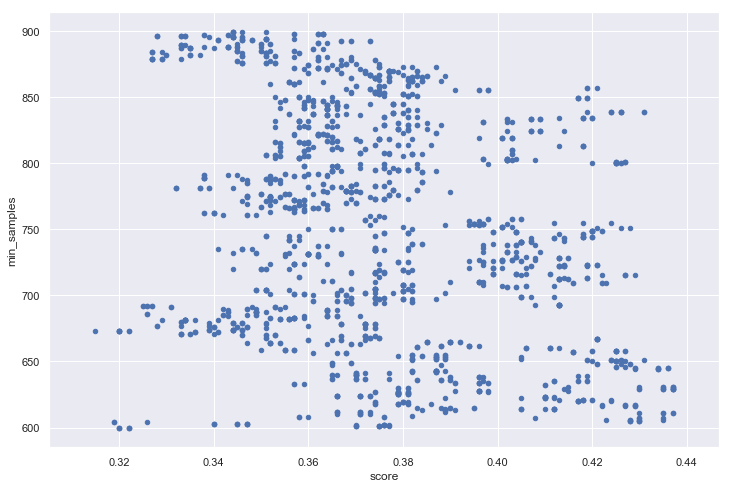

In [26]:
results.to_csv('Hyper-param-search3.csv', index=0)
results.plot.scatter('score','min_samples')

In [ ]:
from sklearn.neighbors import radius_neighbors_graph

coords = df[['x [nm]', 'y [nm]']].sample(frac=0.2).values

test = radius_neighbors_graph(X=coords, radius=100, mode='distance')
# test.todense()

In [8]:
# XY = np.column_stack((df['x [nm]'],df['y [nm]']))[::5]
XY = df[['x [nm]', 'y [nm]']].sample(frac=0.2).values

hdb = hdbscan.HDBSCAN(core_dist_n_jobs=6,min_cluster_size=858,min_samples=644,gen_min_span_tree=True)
_ = hdb.fit(XY)
# hdb.relative_validity_

Estimated number of clusters: 51
Estimated number of noise points: 15529
Total number of points: 179877


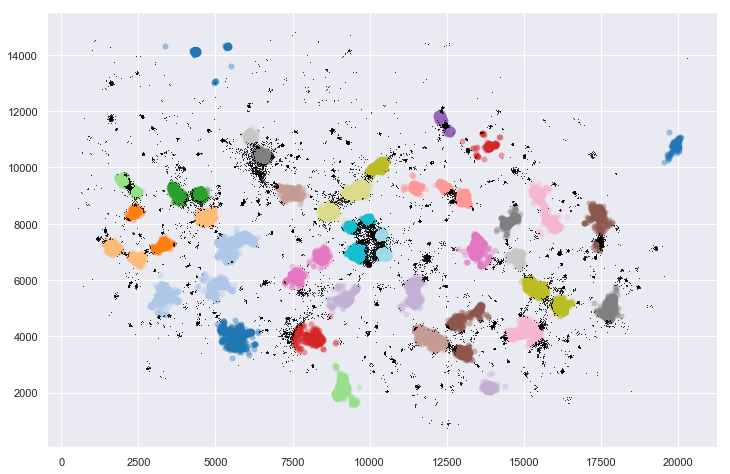

In [9]:
dbscan_verbose(hdb, XY, plot=True,p=0.0)

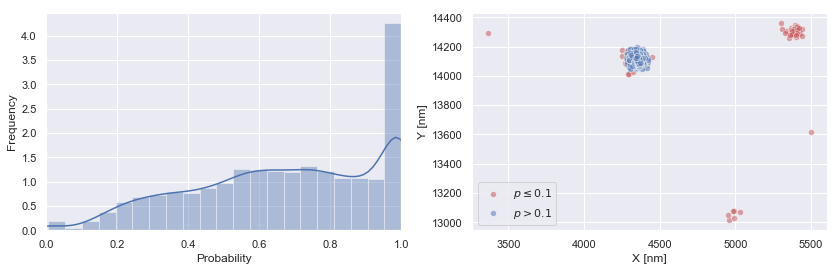

In [21]:
view_cluster(hdb,XY,1,p=0.1)

In [ ]:
dbscan_verbose(hdb, XY, plot=True,p=0.0,silent=True)